In [1]:
import warnings
from pathlib import Path
import numpy as np
import torch
from omegaconf import OmegaConf
from torchvision import transforms

from ldm.models.diffusion.ddim import DDIMSampler
from ldm.util import instantiate_from_config
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
from einops import rearrange
import pickle

In [2]:
device = torch.device('cuda:0')
def load_model_from_config(config, ckpt, device):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    return model


def get_model(config_path,  device, checkpoint):
    config = OmegaConf.load(config_path)
    del config['model']['params']['first_stage_config']['params']['ckpt_path']
    del config['model']['params']['unet_config']['params']['ckpt_path']
    model = load_model_from_config(config, checkpoint, device)
    return model


Download pretrained models from [here](https://github.com/cvlab-stonybrook/PathLDM?tab=readme-ov-file#pretrained-models)

In [3]:
ckpt_path = "plip_imagenet_finetune/checkpoints/epoch_3.ckpt"
config_path = "plip_imagenet_finetune/configs/08-03T09-35-project.yaml"

model = get_model(config_path, device, ckpt_path)
sampler = DDIMSampler(model)

Loading model from plip_imagenet_finetune/checkpoints/epoch_3.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [4]:
summary = "Final Pathologic Diagnosis: Left breast lumpectomy reveals a 4 cm LumA subtype invasive ductal carcinoma (IDC), grade 2, with associated low-to-intermediate grade ductal carcinoma in situ (DCIS) containing necrosis. No tumor infiltrating lymphocytes or lymphovascular invasion identified. Calcifications seen with DCIS and benign epithelium. ER and PR are positive (>90%), HER2 is negative, indicating no over-expression. No evidence of perineural invasion. Negative margins except for anterior margin involvement noted in IDC."

def get_unconditional_token(batch_size):
    return [""]*batch_size

def get_conditional_token(batch_size, summary):

    # append tumor and TIL probability to the summary
    tumor = ["High tumor; low TIL;"]*(batch_size)
    return [t+summary for t in tumor]

In [5]:
batch_size = 16
shape = [3,64,64]

# scale of classifier free guidance 
scale = 1.5

with torch.no_grad():

    #unconditional token for classifier free guidance
    ut = get_unconditional_token(batch_size)
    uc = model.get_learned_conditioning(ut)
    
    ct = get_conditional_token(batch_size, summary)
    cc = model.get_learned_conditioning(ct)
    
    samples_ddim, _ = sampler.sample(50, batch_size, shape, cc, verbose=False, \
                                     unconditional_guidance_scale=scale, unconditional_conditioning=uc, eta=0)
    x_samples_ddim = model.decode_first_stage(samples_ddim)
    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples_ddim = (x_samples_ddim * 255).to(torch.uint8).cpu()

    grid = make_grid(x_samples_ddim, nrow=8)
    
    # to image
    grid = rearrange(grid, 'c h w -> h w c').cpu().numpy()


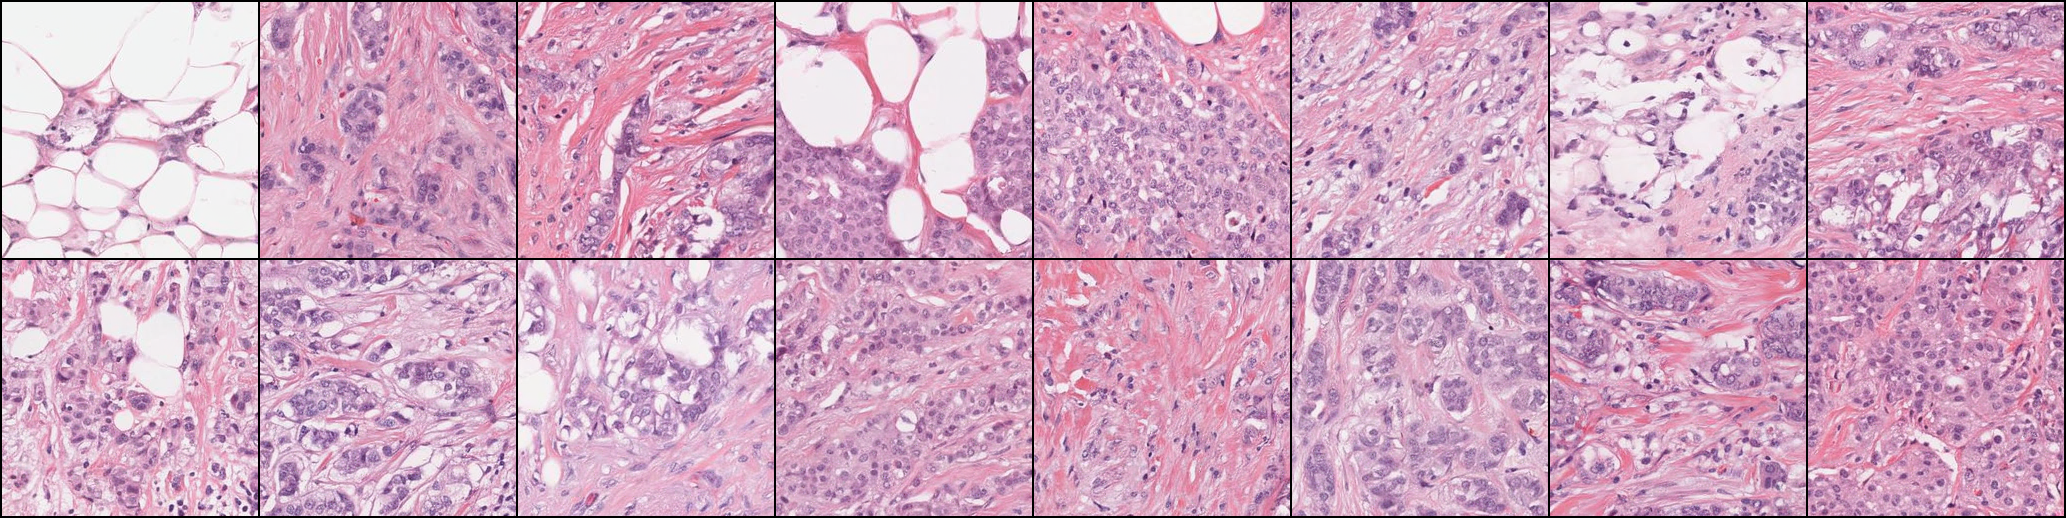

In [6]:
Image.fromarray(grid.astype(np.uint8))